In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Samples = 5000

df = pd.read_csv("C:/Users/ajadhav/Downloads/creditcardfraud/creditcard.csv")
df = df.sample(n=Samples)
df.drop('Time',axis=1,inplace=True)

In [115]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
29211,1.451279,-0.224949,-0.375312,-0.705145,-0.335263,-1.054271,0.116367,-0.461517,-1.371817,0.684133,...,-0.421567,-0.672365,-0.089904,-0.038247,0.548806,1.097709,-0.081151,-0.004831,17.00,0
136794,1.214054,-0.001840,-0.473843,-0.121985,0.307999,-0.407049,0.406034,-0.195526,-0.129071,-0.199935,...,-0.371286,-1.184587,0.020647,-0.733668,0.236753,0.779080,-0.100943,-0.001494,64.93,0
136793,0.520825,-1.879553,-0.282574,-0.161326,-1.411747,-0.719947,0.217149,-0.249617,-1.055603,0.605681,...,-0.129752,-0.797538,-0.364506,0.592375,0.203844,1.017832,-0.156043,0.063420,434.96,0
184434,1.917054,-0.489951,-0.531222,0.087091,-0.566491,-0.443026,-0.491022,0.035915,0.681177,0.235811,...,-0.145123,-0.544621,0.362185,-0.364926,-0.701205,0.236331,-0.059750,-0.049879,48.50,0
170865,-0.284886,0.274839,1.372031,-0.504616,-0.476947,-0.386972,0.440877,0.052276,0.548510,-0.776815,...,0.293967,0.865057,0.003281,0.071302,-0.712969,0.477932,0.142595,0.195652,64.99,0


In [116]:
Fraud = df[df['Class']==1]

Normal = df[df['Class']==0]

outliers_fraction = len(Fraud)/float(len(Normal))

In [117]:
columns = df.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(5000, 29)
(5000,)


In [118]:
len(Normal)

4989

In [119]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(X)

In [120]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm


classifiers = {
    "Support Vector Machine":svm.OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=state)
   
}

In [121]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print(confusion_matrix(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))
    print('________________________________________________')

C:\Users\ajadhav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\classes.py:1177: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Support Vector Machine: 410
Accuracy Score :
0.918
[[4587  402]
 [   8    3]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4989
           1       0.01      0.27      0.01        11

   micro avg       0.92      0.92      0.92      5000
   macro avg       0.50      0.60      0.49      5000
weighted avg       1.00      0.92      0.96      5000

________________________________________________


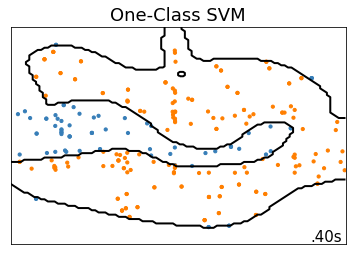

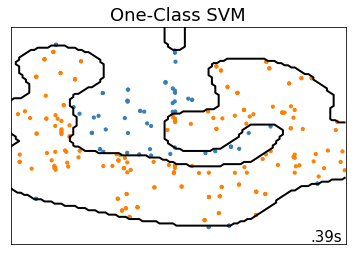

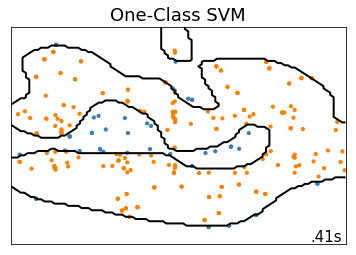

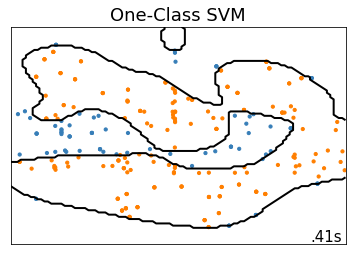

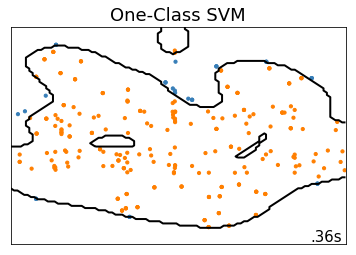

In [124]:
from sklearn.covariance import EllipticEnvelope


anomaly_algorithms = [
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1))]

plot_num = 1
iterations = 5
n_outliers = int(outliers_fraction * Samples)

rng = np.random.RandomState(42)
import time

for j in range(iterations):
    rng.uniform(low=-6, high=6,size=(n_outliers, 2))
    X = np.concatenate([X, rng.uniform(low=-6, high=6,size=(n_outliers, 2))], axis=0)     

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        #plt.subplot(iterations, len(anomaly_algorithms), plot_num)
        if i == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

    plt.show()